# Overview



In [495]:
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence

## Encoder

In [496]:
class Encoder(nn.Module):
    """ 
    Encoder for the sequence-to-sequence math problem assistant model using an LSTM. 
    Converts a sequence of token indices into a hidden representation 
    that will be used by the decoder for sequence generation.
    """
    def __init__(self, input_size, hidden_size, dropout=0.1):
        """
        Initializes the Encoder module.

        Args:
            input_size (int): The size of the input vocabulary.
            hidden_size (int): The number of hidden units in the LSTM.
        """
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        # Embedding layer converts token indices into dense vectors for better representation.
        # The embeddings refer to vector representations of words or tokens used as input to the model.
        # Instead of feeding raw word indices (which don’t capture meaning), feedingembeddings allows
        # the LSTM to learn meaningful semantic relationships between words.
        self.embedding = nn.Embedding(input_size, hidden_size)
        # LSTM layer processes embedded input sequences to generate hidden states
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        # Dropout layer to prevent overfitting
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_seq):
        """
        Forward pass through the encoder.

        Args:
            input_seq (Tensor): Tensor containing token indices for a batch of input sentences.

        Returns:
            outputs (Tensor): Encoder outputs at each time step.
            hidden (Tensor): Final hidden state of the LSTM.
            cell (Tensor): Final cell state of the LSTM.
        """
        embedded = self.embedding(input_seq)            # Convert input tokens into embeddings 
        outputs, (hidden, cell) = self.lstm(embedded)   # Process embeddings through LSTM
        return outputs, (hidden, cell)

## Attention

In [497]:
class Attention(nn.Module):
    """ 
    Attention model for the sequence-to-sequence math problem assistant
    which implements a 'Bahdanau attention' mechanism. This allows the model
    to dynamically compute attention scores based on the decoder's hidden
    state and the encoder's outputs, allowing the model to focus on relevant
    parts of the input sequence at each decoding step.
    """
    def __init__(self, hidden_size, dropout=0.1):
        """
        Initializes the attention mechanism.

        Args:
            hidden_size (int): The size of the hidden state of the LSTM.
        """
        super(Attention, self).__init__()
        # Learnable linear transformation to compute alignment scores
        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        # Learnable parameter to compute weighted attention scores
        self.v = nn.Parameter(torch.rand(hidden_size))
        # Dropout layer to prevent overfitting
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, hidden, encoder_outputs):
        """
        Computes attention weights using Bahdanau's additive attention method.

        Args:
            hidden (Tensor): Decoder hidden state at the current time step.
            encoder_outputs (Tensor): Encoder outputs at all time steps.

        Returns:
            attention_weights (Tensor): Softmax-normalized attention scores.
        """
        seq_len = encoder_outputs.size(1)
        # Expand the hidden state across sequence length to match encoder outputs
        hidden = hidden.unsqueeze(1).repeat(1, seq_len, 1)
        # Compute energy scores (alignment) using a feed-forward layer
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        # Transpose energy tensor for matrix multiplication with attention parameter
        energy = energy.permute(0, 2, 1)
        # Expand attention parameter across batch size
        v = self.v.repeat(encoder_outputs.size(0), 1).unsqueeze(1)
        # Compute attention weights using learned vector `v`
        attention_weights = torch.bmm(v, energy).squeeze(1)
        # Apply softmax to normalize scores across sequence length
        return torch.softmax(attention_weights, dim=1)

## Decoder

In [498]:
class Decoder(nn.Module):
    """ 
    Encoder for the sequence-to-sequence math problem assistant model using an
    LSTM with Bahdanau attention. The decoder generates output tokens one by one
    while dynamically focusing  on relevant parts of the encoder’s outputs using
    the attention mechanism.
    """
    def __init__(self, output_size, hidden_size, dropout=0.1):
        """
        Initializes the Decoder module.

        Args:
            output_size (int): The size of the output vocabulary.
            hidden_size (int): The number of hidden units in the LSTM.
        """
        super(Decoder, self).__init__()
        # Embedding layer converts token indices into dense vectors
        self.embedding = nn.Embedding(output_size, hidden_size)
        # LSTM layer processes embeddings and maintains hidden state across timesteps
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        # Linear layer maps concatenated attention context & LSTM output to vocab space
        self.fc = nn.Linear(hidden_size * 2, output_size)
        # Dropout layer to prevent overfitting
        self.dropout = nn.Dropout(dropout)  
        # Attention mechanism for dynamic focus on encoder outputs
        self.attention = Attention(hidden_size)

    def forward(self, input, hidden, cell, encoder_outputs):
        """
        Forward pass for the decoder.

        Args:
            input (Tensor): Current token input to the decoder.
            hidden (Tensor): Previous hidden state from the LSTM.
            cell (Tensor): Previous cell state from the LSTM.
            encoder_outputs (Tensor): Encoder outputs from all timesteps.

        Returns:
            output (Tensor): Predicted token probabilities.
            hidden (Tensor): Updated hidden state.
            cell (Tensor): Updated cell state.
            attention_weights (Tensor): Attention scores for each encoder timestep.
        """
        # Expand input dimensions to match expected input shape for embedding
        input = input.unsqueeze(1)  
        # Convert token indices into dense embeddings
        embedded = self.embedding(input)
        # Forward pass through LSTM to generate new hidden and cell states
        lstm_output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        # Compute attention weights using the current hidden state and encoder outputs
        attention_weights = self.attention(hidden[-1], encoder_outputs)
        # Apply attention: generate weighted sum of encoder outputs
        context = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs)
        # Flatten tensors for the fully connected layer
        lstm_output = lstm_output.squeeze(1)
        context = context.squeeze(1)
        # Generate token probabilities using concatenated LSTM output and attention context
        output = self.fc(torch.cat((lstm_output, context), dim=1))

        return output, hidden, cell, attention_weights

##  Basic Tokenization and Vocabulary Setup
First, create a vocabulary and tokenize the input sentence (e.g., "two plus four" etc). To keep things extremely simple we'll manually establish a 'word-to-index' vocabulary whihc offers a simple map from word to tokensized integer value.

In [499]:
#Estalish constants
START_OF_SEQUENCE = "<SOS>"
END_OF_SEQUENCE = "<EOS>"
PADDING_SEQUENCE = "<PAD>"

# Tokenization and vocab setup
# Create a vocabulary mapping words to indices
word_to_index = {START_OF_SEQUENCE: 0, END_OF_SEQUENCE: 1, PADDING_SEQUENCE: 2, "two": 3, "plus": 4, "four": 5, "equals": 6, "six": 7, "three": 8, "minus": 9, "one": 10}
index_to_word = {v: k for k, v in word_to_index.items()}  # Reverse mapping for decoding

# Example input and target sequences
input_sentence = "two plus four"
target_sentence = "equals six"

# Test Tokenized input and targets
input_tokens = [word_to_index[word] for word in input_sentence.split()]
target_tokens = [word_to_index[START_OF_SEQUENCE]] + [word_to_index[word] for word in target_sentence.split()] + [word_to_index[END_OF_SEQUENCE]]

## Generate the math problem dataset from the tokenzied data

In [500]:
class BasicMathWordProblemDataset(Dataset):
    def __init__(self, input_sentences, target_sentences, word_to_index):
        self.input_data = [[word_to_index[word] for word in sentence.split()] for sentence in input_sentences]
        self.target_data = [[word_to_index[START_OF_SEQUENCE]] +
                            [word_to_index[word] for word in sentence.split()] +
                            [word_to_index[END_OF_SEQUENCE]] for sentence in target_sentences]

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        return torch.tensor(self.input_data[idx], dtype=torch.long), torch.tensor(self.target_data[idx], dtype=torch.long)

# Example data
input_sentences = ["two plus four"]
target_sentences = ["equals six"]

# Create dataset and dataloader
dataset = BasicMathWordProblemDataset(input_sentences, target_sentences, word_to_index)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

## Establish hyperparamters

In [501]:
# Define the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the encoder and decoder
input_size = len(word_to_index)  # Total vocabulary size
output_size = len(word_to_index)  # Vocabulary size
hidden_size = 128

encoder = Encoder(input_size, hidden_size).to(device)
decoder = Decoder(output_size, hidden_size).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=word_to_index[PADDING_SEQUENCE])  # Ignore padding tokens
encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.001)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.001)
attention_matrix = []  # Store attention weights for visualization

## Plot 

In [502]:
import matplotlib.pyplot as plt


def plot_loss(epoch_losses):
    """Plots the training loss over epochs."""
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o', label='Training Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.legend()
    plt.grid()
    plt.show()

## Establish the training regime

In [503]:
def train(num_epochs, encoder_save_name, decoder_save_name):
    """
    Trains the sequence-to-sequence model using an encoder-decoder architecture.

    Args:
        num_epochs (int): Number of training epochs.
        encoder_save_name (str): File name for saving the trained encoder model.
        decoder_save_name (str): File name for saving the trained decoder model.
    """
    # To store loss values for each epoch
    epoch_losses = []  

    for epoch in range(num_epochs):
        # Accumulate loss for the epoch
        epoch_loss = 0  
        for input_seq, target_seq in dataloader:
            # Move data to GPU if available, else keep on CPU
            input_seq, target_seq = input_seq.to(device), target_seq.to(device)

            # Reset gradients before each batch
            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()

            # **ENCODER FORWARD PASS**
            # Processes the input sequence and generates context for the decoder
            encoder_outputs, (hidden, cell) = encoder(input_seq)

            # **DECODER INITIALIZATION**
            # The first input to the decoder is always the <SOS> token
            decoder_input = torch.tensor([word_to_index[START_OF_SEQUENCE]] * input_seq.size(0), device=device)
            decoder_hidden, decoder_cell = hidden, cell

            # Compute actual target sequence lengths (excluding padding)
            target_lengths = (target_seq != word_to_index[PADDING_SEQUENCE]).sum(dim=1)
            max_target_length = target_lengths.max().item()  # Maximum sequence length in batch

            loss = 0  # Track loss per batch
            
            # **ITERATE OVER TARGET SEQUENCE (Adaptive length)**
            for t in range(max_target_length):
                # Check if sequences are still active (haven't reached <EOS>)
                still_active = t < target_lengths
                if not still_active.any():  # If all sequences are finished, stop decoding
                    break

                # **DECODER FORWARD PASS**
                output, decoder_hidden, decoder_cell, attention_weights = decoder(
                    decoder_input, decoder_hidden, decoder_cell, encoder_outputs
                )

                # Compute masked loss (only valid tokens contribute to loss)
                loss += (criterion(output, target_seq[:, t]) * still_active.float()).sum() / still_active.sum()

                # Apply teacher forcing: Use actual target token as next input
                decoder_input = target_seq[:, t]  

            # **BACKPROPAGATION & OPTIMIZATION**
            loss.backward()  # Compute gradients
            encoder_optimizer.step()  # Update encoder weights
            decoder_optimizer.step()  # Update decoder weights

            epoch_loss += loss.item()
            
        epoch_losses.append(loss.item())

        # Print epoch loss for tracking progress
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}")
        attention_matrix.append(attention_weights.cpu().detach().numpy())  # Convert to NumPy for plotting
    
    plot_loss(epoch_losses)


    # **SAVE TRAINED MODELS**
    torch.save(encoder.state_dict(), f"{encoder_save_name}.pth")
    torch.save(decoder.state_dict(), f"{decoder_save_name}.pth")

## Train the model

Epoch 1/100, Loss: 9.829961776733398
Epoch 2/100, Loss: 9.082291603088379
Epoch 3/100, Loss: 8.38336181640625
Epoch 4/100, Loss: 7.704303741455078
Epoch 5/100, Loss: 7.038985252380371
Epoch 6/100, Loss: 6.393716812133789
Epoch 7/100, Loss: 5.779597282409668
Epoch 8/100, Loss: 5.207958221435547
Epoch 9/100, Loss: 4.687144756317139
Epoch 10/100, Loss: 4.219973564147949
Epoch 11/100, Loss: 3.8036515712738037
Epoch 12/100, Loss: 3.4321179389953613
Epoch 13/100, Loss: 3.0989105701446533
Epoch 14/100, Loss: 2.79890513420105
Epoch 15/100, Loss: 2.5285544395446777
Epoch 16/100, Loss: 2.285132646560669
Epoch 17/100, Loss: 2.0659875869750977
Epoch 18/100, Loss: 1.8684855699539185
Epoch 19/100, Loss: 1.6903979778289795
Epoch 20/100, Loss: 1.5301320552825928
Epoch 21/100, Loss: 1.3863496780395508
Epoch 22/100, Loss: 1.2573730945587158
Epoch 23/100, Loss: 1.1413097381591797
Epoch 24/100, Loss: 1.0366356372833252
Epoch 25/100, Loss: 0.9423408508300781
Epoch 26/100, Loss: 0.8576151132583618
Epoch 27/

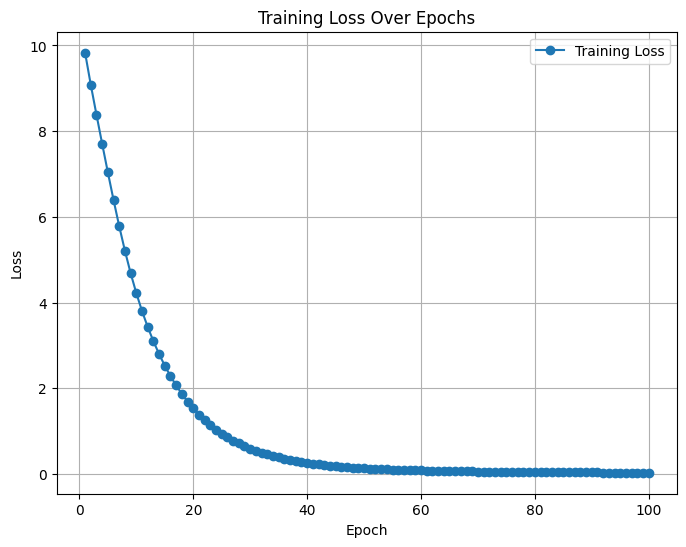

In [504]:
num_epochs = 100  # Define the number of epochs
train(num_epochs, "basic_math_problem_encoder", "basic_math_problem_decoder")

## Generate heatmap

In [505]:
import matplotlib.pyplot as plt
import numpy as np

def plot_attention(input_tokens, output_tokens, attention_matrix):
    """
    Plot the attention weights as a heatmap.

    Args:
        input_tokens (list of str): Tokens in the input sequence.
        output_tokens (list of str): Tokens in the output sequence.
        attention_matrix (np.array): Attention weights matrix (output_tokens x input_tokens).
    """
    plt.figure(figsize=(8, 6))
    plt.imshow(attention_matrix, cmap="viridis", interpolation="nearest")
    plt.xticks(ticks=np.arange(len(input_tokens)), labels=input_tokens, rotation=45, ha="right")
    plt.yticks(ticks=np.arange(len(output_tokens)), labels=output_tokens)
    plt.colorbar(label="Attention Weight")
    plt.xlabel("Input Tokens")
    plt.ylabel("Output Tokens")
    plt.title("Attention Heatmap")
    plt.tight_layout()
    plt.show()

## Test setup

In [506]:
def test(encoder, decoder, input_sentence, word_to_index, index_to_word, max_target_length=100, with_attention_plot=False):
    # Set the models to evaluation mode
    encoder.eval()
    decoder.eval()

    # Tokenize the input sentence
    input_tokens = [word_to_index[word] for word in input_sentence.split()]
    input_seq = torch.tensor(input_tokens, dtype=torch.long).unsqueeze(0)  # Add batch dimension

    # Forward pass through the encoder
    encoder_outputs, (hidden, cell) = encoder(input_seq)

    # Initialize the decoder
    decoder_input = torch.tensor([word_to_index[START_OF_SEQUENCE]], dtype=torch.long)  # Start-of-Sequence token
    decoder_hidden = hidden
    decoder_cell = cell

    # Generate output sequence and collect attention weights
    output_sequence = []
    attention_matrices = []

    for _ in range(max_target_length):
        output, decoder_hidden, decoder_cell, attention_weights = decoder(
            decoder_input, decoder_hidden, decoder_cell, encoder_outputs
        )
        predicted_token = output.argmax(1).item()  # Get the token with the highest probability

        if predicted_token == word_to_index[END_OF_SEQUENCE]:  # Stop at End-of-Sequence token
            break

        output_sequence.append(predicted_token)
        attention_matrices.append(attention_weights.cpu().detach().numpy())  # Save attention weights

        decoder_input = torch.tensor([predicted_token], dtype=torch.long)  # Next decoder input

    # Convert input and output tokens to words
    input_sentence_tokens = [index_to_word[token] for token in input_tokens]
    output_sentence_tokens = [index_to_word[token] for token in output_sequence]

    # Stack attention matrices into a 2D array (output_tokens x input_tokens)
    attention_matrix = np.vstack(attention_matrices)

    # Print the input and output sentences
    print("Input Sentence:", input_sentence_tokens)
    print("Generated Sentence:", output_sentence_tokens)
    print("Attention Weights Shape:", attention_matrix)

    # Visualize attention
    if with_attention_plot:
        # Plot the attention weights
        plot_attention(input_sentence_tokens, output_sentence_tokens, attention_matrix)

    # Convert token indices to words
    return [index_to_word[token] for token in output_sequence]

## Test the trained model

In [507]:
# load the trained model
input_size = len(word_to_index)  # Same as during training
output_size = len(word_to_index)
hidden_size = 128  # Same as during training

encoder = Encoder(input_size, hidden_size)
decoder = Decoder(output_size, hidden_size)

# Load the trained weights
encoder.load_state_dict(torch.load("basic_math_problem_encoder.pth"))
decoder.load_state_dict(torch.load("basic_math_problem_decoder.pth"))

input_sentence = "one plus two"

word_to_index = {START_OF_SEQUENCE: 0, END_OF_SEQUENCE: 1, PADDING_SEQUENCE: 2, "two": 3, "plus": 4, "four": 5, "equals": 6, "six": 7, "three": 8, "minus": 9, "one": 10}
index_to_word = {v: k for k, v in word_to_index.items()}  # Reverse mapping for decoding

# Test and visualize
test(encoder, decoder, input_sentence, word_to_index, index_to_word)

Input Sentence: ['one', 'plus', 'two']
Generated Sentence: ['<SOS>', 'equals', 'six']
Attention Weights Shape: [[0.01256984 0.7445751  0.24285501]
 [0.01300371 0.7104572  0.27653906]
 [0.01379977 0.7035549  0.28264526]]


['<SOS>', 'equals', 'six']

# Establish a more complex dataset and train

## Establish a baseline vocabulary and tokenization capability

In [508]:
# Define special tokens
word_to_index = {START_OF_SEQUENCE: 0, END_OF_SEQUENCE: 1, PADDING_SEQUENCE: 2}  # establish only the baseline tokens this time
 
# Function to tokenize a sentence and update mapping dynamically
def tokenize(sentence, word_to_index):
    tokens = []
    for word in sentence.lower().split():
        if word not in word_to_index:
            word_to_index[word] = len(word_to_index)  # Assign index to new words
        tokens.append(word_to_index[word])
    return tokens

## Load CSV dataset from file

In [509]:
# Load dataset from CSV
def load_sequences_from_csv(csv_file):
    df = pd.read_csv(csv_file)
    return df["Problem"].tolist(), df["Solution"].tolist()

csv_file = "simple_math_problems_addition_only.csv"
input_sentences, target_sentences = load_sequences_from_csv(csv_file)

## Tokenize input and target sentences and convert into tensors

In [ ]:
# Tokenize input and target sentences
input_data = [tokenize(sentence, word_to_index) for sentence in input_sentences]
target_data = [[word_to_index[START_OF_SEQUENCE]] + tokenize(sentence, word_to_index) + [word_to_index[END_OF_SEQUENCE]]
               for sentence in target_sentences]

index_to_word = {v: k for k, v in word_to_index.items()}

# Convert tokenized sentences into tensorsj
input_tensors = [torch.tensor(seq) for seq in input_data]
target_tensors = [torch.tensor(seq) for seq in target_data]

## Generate the math problem dataset from the tokenzied data, including padding

In [511]:
# Apply dynamic padding
input_padded = pad_sequence(input_tensors, batch_first=True, padding_value=word_to_index[PADDING_SEQUENCE])
target_padded = pad_sequence(target_tensors, batch_first=True, padding_value=word_to_index[PADDING_SEQUENCE])

class DynamicMathWordProblemDataset(Dataset):
    def __init__(self, input_padded, target_padded):
        self.input_data = input_padded
        self.target_data = target_padded

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        return self.input_data[idx], self.target_data[idx]

dataset = DynamicMathWordProblemDataset(input_padded, target_padded)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

## Establish hyperparamters

Epoch 1/100, Loss: 6.4623703956604
Epoch 2/100, Loss: 4.649549961090088
Epoch 3/100, Loss: 3.9348690509796143
Epoch 4/100, Loss: 2.6225709915161133
Epoch 5/100, Loss: 2.240666627883911
Epoch 6/100, Loss: 1.9333178997039795
Epoch 7/100, Loss: 1.788198471069336
Epoch 8/100, Loss: 1.2530959844589233
Epoch 9/100, Loss: 1.0898926258087158
Epoch 10/100, Loss: 0.8429881930351257
Epoch 11/100, Loss: 0.44983476400375366
Epoch 12/100, Loss: 0.5958748459815979
Epoch 13/100, Loss: 0.4366091191768646
Epoch 14/100, Loss: 0.11507353186607361
Epoch 15/100, Loss: 0.13217270374298096
Epoch 16/100, Loss: 0.05533146113157272
Epoch 17/100, Loss: 0.038543570786714554
Epoch 18/100, Loss: 0.03075176291167736
Epoch 19/100, Loss: 0.025279801338911057
Epoch 20/100, Loss: 0.02074623852968216
Epoch 21/100, Loss: 0.017662139609456062
Epoch 22/100, Loss: 0.015212658792734146
Epoch 23/100, Loss: 0.01293290127068758
Epoch 24/100, Loss: 0.011233851313591003
Epoch 25/100, Loss: 0.009785553440451622
Epoch 26/100, Loss: 0

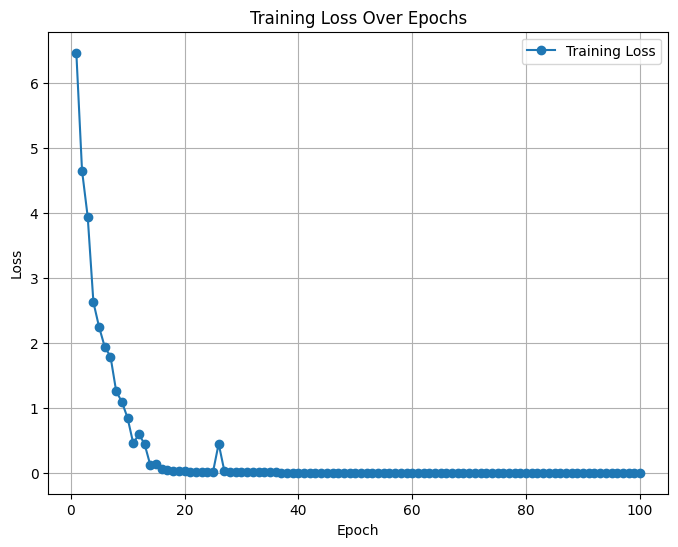

In [512]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_size = len(word_to_index)  # Vocabulary size
output_size = len(word_to_index)
hidden_size = 256

encoder = Encoder(input_size, hidden_size).to(device)
decoder = Decoder(output_size, hidden_size).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=word_to_index[PADDING_SEQUENCE]) # Ignore padding tokens
encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.0005)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.0005)

num_epochs = 100  # Define the number of epochs
train(num_epochs, "addition_only_math_problem_encoder", "addition_only_math_problem_decoder")

# Test the revised model

Input Sentence: ['thirty', 'eight', 'plus', 'twenty', 'six']
Generated Sentence: ['<SOS>', 'sixty', 'four']
Attention Weights Shape: [[3.3071535e-07 4.5672314e-06 1.9056791e-03 8.0683269e-03 9.9002105e-01]
 [3.9622790e-07 3.5338147e-08 9.9999952e-01 1.4690889e-09 4.9341742e-11]
 [6.4965598e-06 2.0177674e-06 9.9971098e-01 2.7896013e-04 1.5673022e-06]]


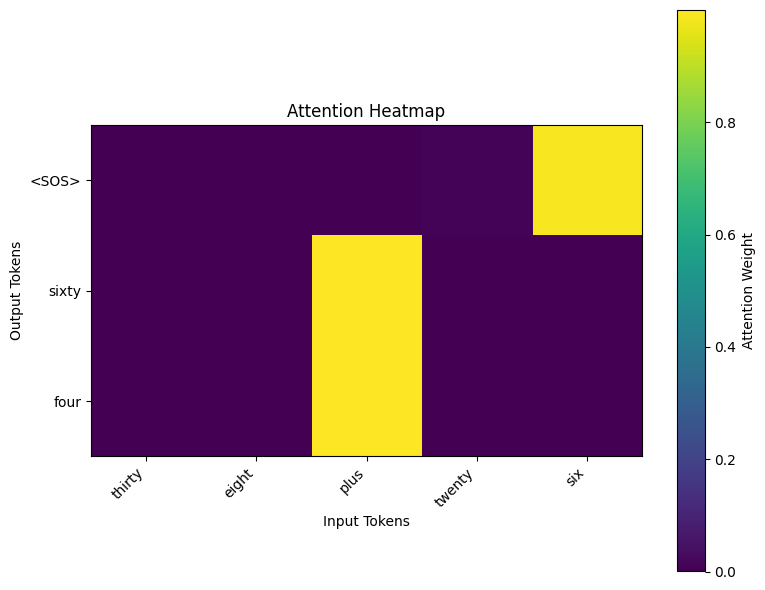

In [513]:
# load the trained model
input_size = len(word_to_index)  # Same as during training
output_size = len(word_to_index)
hidden_size = 256  # Same as during training

encoder = Encoder(input_size, hidden_size)
decoder = Decoder(output_size, hidden_size)

# Load the trained weights
encoder.load_state_dict(torch.load("addition_only_math_problem_encoder.pth"))
decoder.load_state_dict(torch.load("addition_only_math_problem_decoder.pth"))

#thirty eight plus twenty seven,sixty five

input_sentence = "thirty eight plus twenty six" #sixty four

# Test and visualize
test_token_indices_to_words = test(encoder, decoder, input_sentence, word_to_index, index_to_word, with_attention_plot=True)

## Evaluate with edit distance

## Generate the test predictions for evaluation

In [514]:
def generate_predictions(encoder, decoder, input_sentence, word_to_index, index_to_word, max_target_length=10):
    encoder.eval()
    decoder.eval()

    # Tokenize the input sentence
    input_tokens = [word_to_index[word] for word in input_sentence.split()]
    input_seq = torch.tensor(input_tokens, dtype=torch.long).unsqueeze(0)  # Add batch dimension

    # Forward pass through encoder
    encoder_outputs, (hidden, cell) = encoder(input_seq)

    # Initialize decoder with <SOS> token
    decoder_input = torch.tensor([word_to_index[START_OF_SEQUENCE]], dtype=torch.long)
    decoder_hidden, decoder_cell = hidden, cell

    # Generate output sequence
    output_sequence = []
    for _ in range(max_target_length):
        output, decoder_hidden, decoder_cell, _ = decoder(
            decoder_input, decoder_hidden, decoder_cell, encoder_outputs
        )
        predicted_token = output.argmax(1).item()  # Get token with highest probability
        if predicted_token == word_to_index[END_OF_SEQUENCE]:  # Stop at <EOS> token
            break
        output_sequence.append(predicted_token)
        decoder_input = torch.tensor([predicted_token], dtype=torch.long)

    # Convert token indices to words
    return [index_to_word[token] for token in output_sequence]

In [515]:
import edit_distance

def evaluate_with_edit_distance(test_data, encoder, decoder, word_to_index, index_to_word):
    """
    Evaluate the sequence-to-sequence model using edit distance.

    Args:
        test_data (list): List of (input_sentence, ground_truth_sentence) pairs.
        encoder: Trained encoder model.
        decoder: Trained decoder model.
        word_to_index (dict): Word-to-index mapping.
        index_to_word (dict): Index-to-word mapping.

    Returns:
        float: Average edit distance across the test dataset.
    """
    total_distance = 0
    for input_sentence, ground_truth_sentence in test_data:
        # Generate predicted sequence
        predicted_sentence = generate_predictions(encoder, decoder, input_sentence, word_to_index, index_to_word)

        # Compute edit distance
        distance = edit_distance.SequenceMatcher(a=ground_truth_sentence, b=predicted_sentence).distance()
        total_distance += distance

        # Debugging: Print example results
        print(f"Input: {input_sentence}")
        print(f"Ground Truth: {ground_truth_sentence}")
        print(f"Predicted: {predicted_sentence}")
        print(f"Edit Distance: {distance}\n")

    # Calculate average edit distance
    average_distance = total_distance / len(test_data)
    print(f"Average Edit Distance: {average_distance}")
    return average_distance

## Evaluate using edit distance

In [516]:
# Example dataset: [(input_sentence, ground_truth_sentence)]
test_data = [
    ("thirty eight plus twenty six", [START_OF_SEQUENCE, "sixty", "four"]),
    ("thirty eight plus twenty five", [START_OF_SEQUENCE, "sixty", "three"]),
    ("thirty eight plus twenty four", [START_OF_SEQUENCE, "sixty", "two"]),
    ("thirty eight plus twenty three", [START_OF_SEQUENCE, "sixty", "one"]),
    ("thirty eight plus twenty two", [START_OF_SEQUENCE, "sixty"]),
    ("thirty eight plus twenty one", [START_OF_SEQUENCE, "fifty", "nine"]),
    ("thirty eight plus twenty", [START_OF_SEQUENCE, "fifty", "eight"]),
    ("thirty eight plus nineteen", [START_OF_SEQUENCE, "fifty", "seven"]),
    ("thirty eight plus eighteen", [START_OF_SEQUENCE, "fifty", "six"]),
    ("thirty eight plus seventeen", [START_OF_SEQUENCE, "fifty", "five"]),
]

# Assume you have trained encoder and decoder models
average_distance = evaluate_with_edit_distance(
    test_data, encoder, decoder, word_to_index, index_to_word
)

Input: thirty eight plus twenty six
Ground Truth: ['<SOS>', 'sixty', 'four']
Predicted: ['<SOS>', 'sixty', 'four']
Edit Distance: 0

Input: thirty eight plus twenty five
Ground Truth: ['<SOS>', 'sixty', 'three']
Predicted: ['<SOS>', 'sixty', 'three']
Edit Distance: 0

Input: thirty eight plus twenty four
Ground Truth: ['<SOS>', 'sixty', 'two']
Predicted: ['<SOS>', 'sixty', 'two']
Edit Distance: 0

Input: thirty eight plus twenty three
Ground Truth: ['<SOS>', 'sixty', 'one']
Predicted: ['<SOS>', 'sixty', 'one']
Edit Distance: 0

Input: thirty eight plus twenty two
Ground Truth: ['<SOS>', 'sixty']
Predicted: ['<SOS>', 'sixty']
Edit Distance: 0

Input: thirty eight plus twenty one
Ground Truth: ['<SOS>', 'fifty', 'nine']
Predicted: ['<SOS>', 'fifty', 'nine']
Edit Distance: 0

Input: thirty eight plus twenty
Ground Truth: ['<SOS>', 'fifty', 'eight']
Predicted: ['<SOS>', 'seventy', 'four']
Edit Distance: 2

Input: thirty eight plus nineteen
Ground Truth: ['<SOS>', 'fifty', 'seven']
Predicte

## Add positional encodings

In [517]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.1, max_seq_len=100):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.positional_encodings = nn.Embedding(max_seq_len, hidden_size)  # Positional encodings
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_seq):
        positions = torch.arange(0, input_seq.size(1), device=input_seq.device).unsqueeze(0)
        positional_enc = self.positional_encodings(positions)
        embedded = self.dropout(self.embedding(input_seq) + positional_enc)  # Add positional encodings
        outputs, (hidden, cell) = self.lstm(embedded)
        return outputs, (hidden, cell)

## Tune hyperparameters

In [518]:
# Objective function for hyperparameter tuning
def objective(trial):
    # Suggest hyperparameters to be tuned
    hidden_size = trial.suggest_int("hidden_size", 128, 512)  # Hidden layer size
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)  # LR (log-scaled search)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)  # Dropout rate
    
    # Define encoder-decoder with suggested hyperparameters
    encoder = Encoder(input_size, hidden_size).to(device)
    decoder = Decoder(output_size, hidden_size).to(device)

    # Apply dropout in LSTM layers
    encoder.lstm.dropout = dropout_rate
    decoder.lstm.dropout = dropout_rate

    criterion = nn.CrossEntropyLoss(ignore_index=word_to_index[PADDING_SEQUENCE])
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)

    # Run one epoch to evaluate hyperparameter performance
    total_loss = 0
    for input_seq, target_seq in dataloader:
        input_seq, target_seq = input_seq.to(device), target_seq.to(device)
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, (hidden, cell) = encoder(input_seq)
        decoder_input = torch.tensor([word_to_index[START_OF_SEQUENCE]] * input_seq.size(0), device=device)
        decoder_hidden, decoder_cell = hidden, cell

        loss = 0
        for t in range(target_seq.size(1)):
            output, decoder_hidden, decoder_cell, _ = decoder(decoder_input, decoder_hidden, decoder_cell, encoder_outputs)
            loss += criterion(output, target_seq[:, t])
            decoder_input = target_seq[:, t]  # Teacher forcing
        
        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()
        total_loss += loss.item()

    return total_loss / len(dataloader)  # Optuna minimizes this loss

## Perform optimum hyperparameter search


Best hyperparameters: {'hidden_size': 283, 'learning_rate': 0.004869044905756817, 'dropout_rate': 0.28901830138217327}

In [519]:
import optuna

study = optuna.create_study(direction="minimize")  # Minimize loss
study.optimize(objective, n_trials=30)  # Run 30 optimization trials

# Print best hyperparameter combination
best_params = study.best_params
print("Best hyperparameters:", best_params)

best_hidden_size = best_params["hidden_size"]
best_learning_rate = best_params["learning_rate"]
best_dropout_rate = best_params["dropout_rate"]

[I 2025-04-05 17:59:43,104] A new study created in memory with name: no-name-364e563c-ff7a-4405-899f-0b13c18bf285
[I 2025-04-05 17:59:51,668] Trial 0 finished with value: 17.611133053044604 and parameters: {'hidden_size': 196, 'learning_rate': 6.428144892037084e-05, 'dropout_rate': 0.2980171730927389}. Best is trial 0 with value: 17.611133053044604.
[I 2025-04-05 17:59:59,516] Trial 1 finished with value: 7.188174487678868 and parameters: {'hidden_size': 173, 'learning_rate': 0.008220457977359734, 'dropout_rate': 0.2371433699999523}. Best is trial 1 with value: 7.188174487678868.
[I 2025-04-05 18:00:06,380] Trial 2 finished with value: 13.472163054593809 and parameters: {'hidden_size': 149, 'learning_rate': 0.0002237712578817807, 'dropout_rate': 0.10791390000206685}. Best is trial 1 with value: 7.188174487678868.
[I 2025-04-05 18:00:13,073] Trial 3 finished with value: 12.358794470501554 and parameters: {'hidden_size': 139, 'learning_rate': 0.00033952360349179055, 'dropout_rate': 0.242

Best hyperparameters: {'hidden_size': 353, 'learning_rate': 0.002790905796464784, 'dropout_rate': 0.21398011687127674}


## Train with k-fold

In [ ]:
from sklearn.model_selection import KFold
from torch.utils.data import Subset

def train_with_k_fold(num_epochs, encoder_save_name, decoder_save_name, k_folds=5):
    """
    Implements k-fold cross-validation for training the sequence-to-sequence model.

    Args:
        num_epochs (int): Number of epochs for training each fold.
        encoder_save_name (str): Base name for saving the trained encoder model.
        decoder_save_name (str): Base name for saving the trained decoder model.
        k_folds (int): Number of folds for cross-validation.
    """
    # Create k-fold object
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    fold_index = 1  # Track the current fold
    for train_indices, val_indices in kfold.split(dataset):  # `dataset` should be preloaded
        
        # Split dataset into training and validation sets for the current fold
        train_data = Subset(dataset, train_indices)
        val_data = Subset(dataset, val_indices)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
        
        print(f"Training fold {fold_index}/{k_folds}...")
        
        # Reset models and optimizers for each fold
        encoder.apply(weight_init)  # `weight_init` resets model weights
        decoder.apply(weight_init)
        encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=learning_rate)
        decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate)
        
        # Train for the specified number of epochs
        for epoch in range(num_epochs):
            epoch_loss = 0
            for input_seq, target_seq in train_loader:
                input_seq, target_seq = input_seq.to(device), target_seq.to(device)
                
                encoder_optimizer.zero_grad()
                decoder_optimizer.zero_grad()
                
                # **ENCODER & DECODER TRAINING LOGIC (Same as your original code)** #
                encoder_outputs, (hidden, cell) = encoder(input_seq)
                decoder_input = torch.tensor([word_to_index[START_OF_SEQUENCE]] * input_seq.size(0), device=device)
                decoder_hidden, decoder_cell = hidden, cell
                
                target_lengths = (target_seq != word_to_index[PADDING_SEQUENCE]).sum(dim=1)
                max_target_length = target_lengths.max().item()
                loss = 0
                
                for t in range(max_target_length):
                    still_active = t < target_lengths
                    if not still_active.any():
                        break

                    output, decoder_hidden, decoder_cell, _ = decoder(
                        decoder_input, decoder_hidden, decoder_cell, encoder_outputs
                    )
                    
                    loss += (criterion(output, target_seq[:, t]) * still_active.float()).sum() / still_active.sum()
                    decoder_input = target_seq[:, t]

                loss.backward()
                encoder_optimizer.step()
                decoder_optimizer.step()
                
                epoch_loss += loss.item()
            
            print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")
        
        # Evaluate the model on the validation set
        val_loss = evaluate_model(val_loader)  # Define a validation evaluation function
        print(f"Validation Loss for fold {fold_index}: {val_loss:.4f}")
        
        # Save the models for the current fold
        torch.save(encoder.state_dict(), f"{encoder_save_name}_fold{fold_index}.pth")
        torch.save(decoder.state_dict(), f"{decoder_save_name}_fold{fold_index}.pth")
        
        fold_index += 1

    print("K-fold cross-validation complete!")

def evaluate_model(dataloader):
    """
    Evaluate the model on the validation set and compute loss.

    Args:
        dataloader: DataLoader for the validation set.

    Returns:
        float: Validation loss.
    """
    encoder.eval()
    decoder.eval()
    val_loss = 0
    with torch.no_grad():
        for input_seq, target_seq in dataloader:
            input_seq, target_seq = input_seq.to(device), target_seq.to(device)
            
            encoder_outputs, (hidden, cell) = encoder(input_seq)
            decoder_input = torch.tensor([word_to_index[START_OF_SEQUENCE]] * input_seq.size(0), device=device)
            decoder_hidden, decoder_cell = hidden, cell
            
            target_lengths = (target_seq != word_to_index[PADDING_SEQUENCE]).sum(dim=1)
            max_target_length = target_lengths.max().item()
            
            for t in range(max_target_length):
                still_active = t < target_lengths
                if not still_active.any():
                    break

                output, decoder_hidden, decoder_cell, _ = decoder(
                    decoder_input, decoder_hidden, decoder_cell, encoder_outputs
                )
                
                val_loss += (criterion(output, target_seq[:, t]) * still_active.float()).sum().item() / still_active.sum().item()
                decoder_input = target_seq[:, t]
    
    return val_loss / len(dataloader)

## Implement hyperparameter changes and re-test

Epoch 1/100, Loss: 5.79155158996582
Epoch 2/100, Loss: 4.2169060707092285
Epoch 3/100, Loss: 3.3025856018066406
Epoch 4/100, Loss: 3.346982717514038
Epoch 5/100, Loss: 2.9935333728790283
Epoch 6/100, Loss: 2.557953119277954
Epoch 7/100, Loss: 2.5647199153900146
Epoch 8/100, Loss: 2.121936798095703
Epoch 9/100, Loss: 2.028315782546997
Epoch 10/100, Loss: 1.8725872039794922
Epoch 11/100, Loss: 1.6407252550125122
Epoch 12/100, Loss: 1.4996930360794067
Epoch 13/100, Loss: 1.4750980138778687
Epoch 14/100, Loss: 1.2516177892684937
Epoch 15/100, Loss: 1.1826603412628174
Epoch 16/100, Loss: 1.1759964227676392
Epoch 17/100, Loss: 0.8210497498512268
Epoch 18/100, Loss: 0.7024474143981934
Epoch 19/100, Loss: 0.6879965662956238
Epoch 20/100, Loss: 0.4383533298969269
Epoch 21/100, Loss: 0.33662185072898865
Epoch 22/100, Loss: 0.24181906878948212
Epoch 23/100, Loss: 0.16301150619983673
Epoch 24/100, Loss: 0.2451656013727188
Epoch 25/100, Loss: 0.3671249747276306
Epoch 26/100, Loss: 0.104774512350559

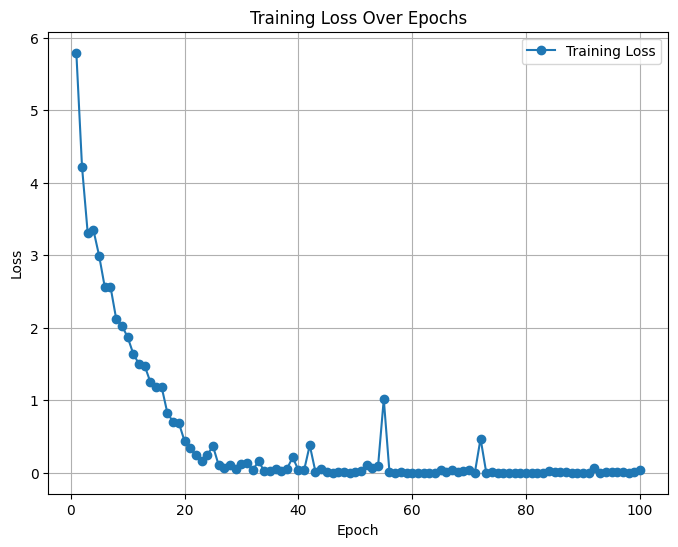

In [520]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_size = len(word_to_index)  # Vocabulary size
output_size = len(word_to_index)
hidden_size = best_hidden_size  # Use best hidden size from tuning
dropout_rate = best_dropout_rate # Use best dropout rate from tuning

encoder = Encoder(input_size, hidden_size, dropout_rate).to(device)
decoder = Decoder(output_size, hidden_size, dropout_rate).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=word_to_index[PADDING_SEQUENCE]) # Ignore padding tokens
encoder_optimizer = optim.Adam(encoder.parameters(), lr=best_learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=best_learning_rate)

num_epochs = 100  # Define the number of epochs
train(num_epochs, "addition_only_math_problem_encoder", "addition_only_math_problem_decoder")

## Re-evaluate

In [521]:
# Example dataset: [(input_sentence, ground_truth_sentence)]
test_data = [
    ("thirty eight plus twenty six", [START_OF_SEQUENCE, "sixty", "four"]),
    ("thirty eight plus twenty five", [START_OF_SEQUENCE, "sixty", "three"]),
    ("thirty eight plus twenty four", [START_OF_SEQUENCE, "sixty", "two"]),
    ("thirty eight plus twenty three", [START_OF_SEQUENCE, "sixty", "one"]),
    ("thirty eight plus twenty two", [START_OF_SEQUENCE, "sixty"]),
    ("thirty eight plus twenty one", [START_OF_SEQUENCE, "fifty", "nine"]),
    ("thirty eight plus twenty", [START_OF_SEQUENCE, "fifty", "eight"]),
    ("thirty eight plus nineteen", [START_OF_SEQUENCE, "fifty", "seven"]),
    ("thirty eight plus eighteen", [START_OF_SEQUENCE, "fifty", "six"]),
    ("thirty eight plus seventeen", [START_OF_SEQUENCE, "fifty", "five"]),
]

# Assume you have trained encoder and decoder models
average_distance = evaluate_with_edit_distance(
    test_data, encoder, decoder, word_to_index, index_to_word
)

Input: thirty eight plus twenty six
Ground Truth: ['<SOS>', 'sixty', 'four']
Predicted: ['<SOS>', 'sixty', 'four']
Edit Distance: 0

Input: thirty eight plus twenty five
Ground Truth: ['<SOS>', 'sixty', 'three']
Predicted: ['<SOS>', 'sixty', 'three']
Edit Distance: 0

Input: thirty eight plus twenty four
Ground Truth: ['<SOS>', 'sixty', 'two']
Predicted: ['<SOS>', 'sixty', 'two']
Edit Distance: 0

Input: thirty eight plus twenty three
Ground Truth: ['<SOS>', 'sixty', 'one']
Predicted: ['<SOS>', 'sixty', 'one']
Edit Distance: 0

Input: thirty eight plus twenty two
Ground Truth: ['<SOS>', 'sixty']
Predicted: ['<SOS>', 'sixty']
Edit Distance: 0

Input: thirty eight plus twenty one
Ground Truth: ['<SOS>', 'fifty', 'nine']
Predicted: ['<SOS>', 'fifty', 'nine']
Edit Distance: 0

Input: thirty eight plus twenty
Ground Truth: ['<SOS>', 'fifty', 'eight']
Predicted: ['<SOS>', 'sixty', 'six']
Edit Distance: 2

Input: thirty eight plus nineteen
Ground Truth: ['<SOS>', 'fifty', 'seven']
Predicted: 

######################################################################################################

## K-Fold cross validation

In [522]:
from sklearn.model_selection import KFold
import numpy as np

# Example data
data = np.array(["3 + 5", "12 / 4", "10 * 2", "15 - 7", "20 / 5"])
labels = np.array(["8", "3", "20", "8", "4"])

# Define K-Fold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Splitting the data
for fold, (train_idx, test_idx) in enumerate(kfold.split(data)):
    print(f"Fold {fold + 1}")
    print("Train Indices:", train_idx)
    print("Test Indices:", test_idx)

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

# Placeholders for metrics
fold_metrics = []

for fold, (train_idx, test_idx) in enumerate(kfold.split(data)):
    print(f"Training Fold {fold + 1}")
    
    # Split data
    train_data, test_data = data[train_idx], data[test_idx]
    train_labels, test_labels = labels[train_idx], labels[test_idx]
    
    # Prepare PyTorch Datasets and Dataloaders
    train_dataset = TensorDataset(torch.tensor(train_data), torch.tensor(train_labels))
    test_dataset = TensorDataset(torch.tensor(test_data), torch.tensor(test_labels))
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16)
    
    # Initialize model, optimizer, criterion
    model = Seq2SeqModel()  # Replace with your seq2seq model
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()

    # Train your model
    train_seq2seq(model, train_loader, optimizer, criterion)

    # Evaluate your model
    test_loss = evaluate_seq2seq(model, test_loader, criterion)
    print(f"Fold {fold + 1} Loss: {test_loss:.4f}")
    fold_metrics.append(test_loss)

# Average loss across folds
average_loss = sum(fold_metrics) / len(fold_metrics)
print(f"Average Loss Across Folds: {average_loss:.4f}")

## BLEU score 

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction

def evaluate_seq2seq(encoder, decoder, dataloader, max_target_len):
    encoder.eval()
    decoder.eval()

    references = []  # List of ground truth sequences
    candidates = []  # List of predicted sequences

    with torch.no_grad():
        for input_seq, target_seq in dataloader:
            input_seq = input_seq.to(device)

            # Encoder forward pass
            encoder_outputs, (hidden, cell) = encoder(input_seq)

            # Initialize decoder input (<SOS> token)
            decoder_input = torch.tensor([word_to_index["<SOS>"]] * input_seq.size(0), device=device)
            decoder_hidden, decoder_cell = hidden, cell

            predictions = []
            for t in range(max_target_len):
                # Decoder forward pass
                output, decoder_hidden, decoder_cell = decoder(decoder_input, decoder_hidden, decoder_cell)

                # Get the token with the highest probability
                top_token = output.argmax(1)
                predictions.append(top_token)

                # Stop decoding if <EOS> token is generated
                if top_token.item() == word_to_index["<EOS>"]:
                    break

                decoder_input = top_token

            # Convert predicted and target sequences to words
            predicted_seq = [index_to_word[token.item()] for token in predictions]
            target_seq_words = [[index_to_word[token.item()] for token in target_seq[0]]]

            # Append to BLEU evaluation lists
            references.append(target_seq_words)  # Ground truth
            candidates.append(predicted_seq)  # Model predictions

    # Calculate BLEU
    smooth = SmoothingFunction().method1
    bleu_score = corpus_bleu(references, candidates, smoothing_function=smooth)
    print(f"BLEU Score: {bleu_score:.4f}")
    return bleu_score